In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import shutil

import torch
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg19

from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
inp_path = '/content/drive/MyDrive/Lab2Images/Input'
hr_path = '/content/drive/MyDrive/Lab2Images/HR'
lr_path = '/content/drive/MyDrive/Lab2Images/LR'
imgs = []

lr_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
hr_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

# Extracting training dataset
for img_path in os.listdir(inp_path):
    lr = os.path.join(lr_path, img_path)
    lr = np.array(Image.open(lr))
    lr = lr_normalize(lr)

    hr = os.path.join(hr_path, img_path)
    hr = np.array(Image.open(hr))
    hr = hr_normalize(hr)

    imgs.append((lr, hr))

In [3]:
class TraingImageset(Dataset):
    def __init__(self, images):
        self.images = images

    def __getitem__(self, index):
        return self.images[index]

    def __len__(self):
        return len(self.images)

In [4]:
train_set = TraingImageset(images=imgs)

batch_size = 16
num_workers = 2

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

In [5]:
test_path = '/content/drive/MyDrive/Lab2Images/Test'
# Extracting testing dataset
test_images = []
for img_path in os.listdir(test_path):
    im = os.path.join(test_path, img_path)
    im = np.array(Image.open(im))
    im = lr_normalize(im)

    test_images.append(im)

In [6]:
for i in test_images:
    print(i.shape)

torch.Size([3, 256, 256])
torch.Size([3, 280, 280])
torch.Size([3, 344, 224])
torch.Size([3, 512, 512])
torch.Size([3, 288, 288])


In [7]:
class ConvBlock(nn.Module):
    # Conv -> BN -> Leaky/PReLU
    def __init__(
        self,
        in_chl,
        out_chl,
        discrim=False,
        use_acti=True,
        batch=True,
        **kwargs,
    ):
        super().__init__()
        self.use_acti = use_acti
        self.cnn = nn.Conv2d(in_chl, out_chl, **kwargs, bias= not batch)
        self.bn = nn.BatchNorm2d(out_chl) if batch else nn.Identity()
        self.activation = (
            nn.LeakyReLU(0.2, inplace=True) if discrim
            else nn.PReLU(num_parameters=out_chl)
        )

    def forward(self, x):
        return self.activation(self.bn(self.cnn(x))) if self.use_acti else self.bn(self.cnn(x))

In [8]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_chl, scl_f):
        super().__init__()
        self.conv = nn.Conv2d(in_chl, in_chl * scl_f ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scl_f)  # in channel * 4, Height, Width --> in channel, Height * 2, Width * 3
        self.activation = nn.PReLU(num_parameters=in_chl)

    def forward(self, x):
        return self.activation(self.ps(self.conv(x)))

In [9]:
# Generator residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_chl):
        super().__init__()
        self.block1 = ConvBlock(in_chl, out_chl=in_chl, kernel_size=3, stride=1, padding=1)
        self.block2 = ConvBlock(in_chl, out_chl=in_chl, kernel_size=3, stride=1, padding=1, use_acti=False)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x  # residual connection

In [10]:
class Generator(nn.Module):
    def __init__(self, in_chl=3, num_chl=64, num_blk=16):
        super().__init__()
        self.init = ConvBlock(in_chl, num_chl, kernel_size=9, stride=1, padding=4, batch=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_chl) for _ in range(num_blk)])
        self.convblock = ConvBlock(num_chl, num_chl, kernel_size=3, stride=1, padding=1, use_acti=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_chl, scl_f=2), UpsampleBlock(num_chl, scl_f=2))
        self.output = nn.Conv2d(num_chl, in_chl, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.init(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial  # elementwise sum
        x = self.upsamples(x)
        return torch.tanh(self.output(x))

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_chl=3, feats=(64, 64, 128, 128, 256, 256, 512, 512)):
        super().__init__()
        blocks = []
        for idx, feat in enumerate(feats):
            blocks.append(
                ConvBlock(
                    in_chl,
                    feat,
                    kernel_size=3,
                    stride=1 + (idx % 2),  # stride alternates between 1 and 2
                    padding=1,
                    discrim=True,
                    use_acti=True,
                    batch=False if not idx else True,  # No batch normalization for the first conv block ~ idx == 0
                )
            )
            in_chl = feat

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),  # 96 * 96 -> 128
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

In [12]:
# phi_5, 4 5th conv layer before maxpooling but after activation

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to('cuda')
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_inp_feats = self.vgg(input)
        vgg_trt_feats = self.vgg(target)
        return self.loss(vgg_inp_feats, vgg_trt_feats)

In [13]:
out_dir = '/content/drive/MyDrive/Lab2Images/Output'

def save_gen_image(gen, img, device, ep):
    gen.eval()
    img_tensor = img.unsqueeze(0).to(device)
    fake = gen(img_tensor)
    fake_img = fake.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
    fake_img = Image.fromarray((fake_img * 255.).astype(np.uint8))
    f_name = f"test_at_epoch_{ep}.png"
    fake_img.save(f_name)
    shutil.move(f_name, os.path.join(out_dir, f_name))

In [14]:
def train(data_loader, discrim, gen, disc_optim, gen_optim, mse, bce, vgg_loss, epochs, device, fine_tune=False):
    discrim.train()

    for ep in range(epochs):
        gen.train()
        loop = tqdm(data_loader, leave=True)

        for i, (low_res, hi_res) in enumerate(loop):
            hi_res = hi_res.to(device)
            low_res = low_res.to(device)

            fake = gen(low_res)
            if fine_tune:
                disc_real = discrim(hi_res)
                disc_fake = discrim(fake.detach())
                disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
                disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
                disc_loss = disc_loss_real + disc_loss_fake

                disc_optim.zero_grad()
                disc_loss.backward()
                disc_optim.step()

            l2_loss = mse(fake, hi_res)
            if fine_tune:
                disc_fake = discrim(fake)
                percep_loss = 0.006 * vgg_loss(fake, hi_res)
                adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
                gen_loss = percep_loss + adversarial_loss + l2_loss
            else:
                gen_loss = l2_loss

            gen_optim.zero_grad()
            gen_loss.backward()
            gen_optim.step()

        if not fine_tune and (ep % 10) == 0:
            print(f'Epoch {ep}, loss = {gen_loss.item()}')
            print('=================================')

        if fine_tune and (ep % 10) == 0:
            print(f'Epoch {ep}')
            print(f'Gen loss = {gen_loss.item()} | Discrim loss = {disc_loss.item()}')
            print('=================================================================')

        if not fine_tune and (ep % 200) == 0:
            torch.save(gen.state_dict(), './pre-train/generator_%03d.pt'%ep)

        if fine_tune and (ep % 200) == 0:
            torch.save(gen.state_dict(), './fine-tune/generator_%03d.pt'%ep)
            torch.save(discrim.state_dict(), './fine-tune/discriminator%03d.pt'%ep)

        if fine_tune and (ep % 100) == 0:
            test_img = test_images[random.randint(0, len(test_images) - 1)]
            save_gen_image(gen, test_img, device, ep)


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

if not os.path.exists('pre-train'):
    os.mkdir('pre-train')
if not os.path.exists('fine-tune'):
    os.mkdir('fine-tune')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
generator_op = optim.Adam(generator.parameters(), lr=1e-4)
discriminator_op = optim.Adam(discriminator.parameters(), lr=1e-4)

# Losses
mse = nn.MSELoss()
bce = nn.BCELoss()
vgg_loss = VGGLoss()

epochs = 1000

Working on cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# 1. Train Generator ~ Pre-train model
train(train_loader, discriminator, generator, discriminator_op, generator_op, mse, bce, vgg_loss, epochs, device)

100%|██████████| 32/32 [00:02<00:00, 11.21it/s]


Epoch 0, loss = 0.04021057114005089


100%|██████████| 32/32 [00:01<00:00, 23.14it/s]


Epoch 10, loss = 0.022235747426748276


100%|██████████| 32/32 [00:01<00:00, 22.94it/s]


Epoch 20, loss = 0.018880411982536316


100%|██████████| 32/32 [00:01<00:00, 23.19it/s]


Epoch 30, loss = 0.022020431235432625


100%|██████████| 32/32 [00:01<00:00, 23.01it/s]


Epoch 40, loss = 0.015546519309282303


100%|██████████| 32/32 [00:01<00:00, 22.95it/s]


Epoch 50, loss = 0.01906036026775837


100%|██████████| 32/32 [00:01<00:00, 22.84it/s]


Epoch 60, loss = 0.013909653760492802


100%|██████████| 32/32 [00:01<00:00, 22.97it/s]


Epoch 70, loss = 0.014425260946154594


100%|██████████| 32/32 [00:01<00:00, 23.34it/s]


Epoch 80, loss = 0.01724938675761223


100%|██████████| 32/32 [00:01<00:00, 23.27it/s]


Epoch 90, loss = 0.02017049863934517


100%|██████████| 32/32 [00:01<00:00, 23.29it/s]


Epoch 100, loss = 0.015487989410758018


100%|██████████| 32/32 [00:01<00:00, 23.40it/s]


Epoch 110, loss = 0.013905107975006104


100%|██████████| 32/32 [00:01<00:00, 23.09it/s]


Epoch 120, loss = 0.008733066730201244


100%|██████████| 32/32 [00:01<00:00, 23.22it/s]


Epoch 130, loss = 0.010025492869317532


100%|██████████| 32/32 [00:01<00:00, 23.38it/s]


Epoch 140, loss = 0.018087532371282578


100%|██████████| 32/32 [00:01<00:00, 23.54it/s]


Epoch 150, loss = 0.012815581634640694


100%|██████████| 32/32 [00:01<00:00, 23.37it/s]


Epoch 160, loss = 0.014638584107160568


100%|██████████| 32/32 [00:01<00:00, 23.37it/s]


Epoch 170, loss = 0.013963877223432064


100%|██████████| 32/32 [00:01<00:00, 23.64it/s]


Epoch 180, loss = 0.010904738679528236


100%|██████████| 32/32 [00:01<00:00, 23.32it/s]


Epoch 190, loss = 0.009957642294466496


100%|██████████| 32/32 [00:01<00:00, 23.33it/s]


Epoch 200, loss = 0.011106682941317558


100%|██████████| 32/32 [00:01<00:00, 23.75it/s]


Epoch 210, loss = 0.0073971813544631


100%|██████████| 32/32 [00:01<00:00, 23.22it/s]


Epoch 220, loss = 0.009942013770341873


100%|██████████| 32/32 [00:01<00:00, 23.19it/s]


Epoch 230, loss = 0.007999919354915619


100%|██████████| 32/32 [00:01<00:00, 23.59it/s]


Epoch 240, loss = 0.011648224666714668


100%|██████████| 32/32 [00:01<00:00, 23.36it/s]


Epoch 250, loss = 0.01042182557284832


100%|██████████| 32/32 [00:01<00:00, 23.02it/s]


Epoch 260, loss = 0.008636475540697575


100%|██████████| 32/32 [00:01<00:00, 23.62it/s]


Epoch 270, loss = 0.006670596543699503


100%|██████████| 32/32 [00:01<00:00, 23.46it/s]


Epoch 280, loss = 0.008345028385519981


100%|██████████| 32/32 [00:01<00:00, 23.67it/s]


Epoch 290, loss = 0.009132065810263157


100%|██████████| 32/32 [00:01<00:00, 23.41it/s]


Epoch 300, loss = 0.011614438146352768


100%|██████████| 32/32 [00:01<00:00, 23.33it/s]


Epoch 310, loss = 0.014888936653733253


100%|██████████| 32/32 [00:01<00:00, 23.51it/s]


Epoch 320, loss = 0.007854589261114597


100%|██████████| 32/32 [00:01<00:00, 23.29it/s]


Epoch 330, loss = 0.007757243234664202


100%|██████████| 32/32 [00:01<00:00, 23.39it/s]


Epoch 340, loss = 0.007853229530155659


100%|██████████| 32/32 [00:01<00:00, 23.42it/s]


Epoch 350, loss = 0.007968696765601635


100%|██████████| 32/32 [00:01<00:00, 23.22it/s]


Epoch 360, loss = 0.006596933584660292


100%|██████████| 32/32 [00:01<00:00, 23.35it/s]


Epoch 370, loss = 0.007680822629481554


100%|██████████| 32/32 [00:01<00:00, 23.39it/s]


Epoch 380, loss = 0.007225743494927883


100%|██████████| 32/32 [00:01<00:00, 23.71it/s]


Epoch 390, loss = 0.01033275481313467


100%|██████████| 32/32 [00:01<00:00, 23.25it/s]


Epoch 400, loss = 0.007666384801268578


100%|██████████| 32/32 [00:01<00:00, 23.56it/s]


Epoch 410, loss = 0.006694251671433449


100%|██████████| 32/32 [00:01<00:00, 23.16it/s]


Epoch 420, loss = 0.007035602815449238


100%|██████████| 32/32 [00:01<00:00, 23.18it/s]


Epoch 430, loss = 0.007629374973475933


100%|██████████| 32/32 [00:01<00:00, 23.49it/s]


Epoch 440, loss = 0.00627577118575573


100%|██████████| 32/32 [00:01<00:00, 23.43it/s]


Epoch 450, loss = 0.0059018125757575035


100%|██████████| 32/32 [00:01<00:00, 23.30it/s]


Epoch 460, loss = 0.0064514982514083385


100%|██████████| 32/32 [00:01<00:00, 23.30it/s]


Epoch 470, loss = 0.007110069505870342


100%|██████████| 32/32 [00:01<00:00, 23.40it/s]


Epoch 480, loss = 0.008557351306080818


100%|██████████| 32/32 [00:01<00:00, 23.36it/s]


Epoch 490, loss = 0.007332711946219206


100%|██████████| 32/32 [00:01<00:00, 22.79it/s]


Epoch 500, loss = 0.006534075364470482


100%|██████████| 32/32 [00:01<00:00, 23.14it/s]


Epoch 510, loss = 0.006312871817499399


100%|██████████| 32/32 [00:01<00:00, 23.42it/s]


Epoch 520, loss = 0.007228021044284105


100%|██████████| 32/32 [00:01<00:00, 23.19it/s]


Epoch 530, loss = 0.0053132809698581696


100%|██████████| 32/32 [00:01<00:00, 23.31it/s]


Epoch 540, loss = 0.0065575032494962215


100%|██████████| 32/32 [00:01<00:00, 22.92it/s]


Epoch 550, loss = 0.005933793261647224


100%|██████████| 32/32 [00:01<00:00, 23.26it/s]


Epoch 560, loss = 0.005813973490148783


100%|██████████| 32/32 [00:01<00:00, 22.75it/s]


Epoch 570, loss = 0.008044886402785778


100%|██████████| 32/32 [00:01<00:00, 22.40it/s]


Epoch 580, loss = 0.005688410252332687


100%|██████████| 32/32 [00:01<00:00, 23.05it/s]


Epoch 590, loss = 0.006898084189742804


100%|██████████| 32/32 [00:01<00:00, 23.27it/s]


Epoch 600, loss = 0.008594773709774017


100%|██████████| 32/32 [00:01<00:00, 22.72it/s]


Epoch 610, loss = 0.006169930566102266


100%|██████████| 32/32 [00:01<00:00, 23.56it/s]


Epoch 620, loss = 0.006368075031787157


100%|██████████| 32/32 [00:01<00:00, 23.24it/s]


Epoch 630, loss = 0.0053506032563745975


100%|██████████| 32/32 [00:01<00:00, 23.09it/s]


Epoch 640, loss = 0.005799592938274145


100%|██████████| 32/32 [00:01<00:00, 23.18it/s]


Epoch 650, loss = 0.005355804227292538


100%|██████████| 32/32 [00:01<00:00, 23.10it/s]


Epoch 660, loss = 0.005714785773307085


100%|██████████| 32/32 [00:01<00:00, 23.11it/s]


Epoch 670, loss = 0.007183837238699198


100%|██████████| 32/32 [00:01<00:00, 23.30it/s]


Epoch 680, loss = 0.007312933448702097


100%|██████████| 32/32 [00:01<00:00, 23.70it/s]


Epoch 690, loss = 0.007288824301213026


100%|██████████| 32/32 [00:01<00:00, 23.42it/s]


Epoch 700, loss = 0.00573387835174799


100%|██████████| 32/32 [00:01<00:00, 23.45it/s]


Epoch 710, loss = 0.0057126437313854694


100%|██████████| 32/32 [00:01<00:00, 23.31it/s]


Epoch 720, loss = 0.004836431238800287


100%|██████████| 32/32 [00:01<00:00, 23.22it/s]


Epoch 730, loss = 0.004279167391359806


100%|██████████| 32/32 [00:01<00:00, 23.33it/s]


Epoch 740, loss = 0.0052373893558979034


100%|██████████| 32/32 [00:01<00:00, 23.16it/s]


Epoch 750, loss = 0.0060025774873793125


100%|██████████| 32/32 [00:01<00:00, 23.46it/s]


Epoch 760, loss = 0.005906474776566029


100%|██████████| 32/32 [00:01<00:00, 23.28it/s]


Epoch 770, loss = 0.00493868812918663


100%|██████████| 32/32 [00:01<00:00, 23.53it/s]


Epoch 780, loss = 0.006656717509031296


100%|██████████| 32/32 [00:01<00:00, 23.52it/s]


Epoch 790, loss = 0.0059072403237223625


100%|██████████| 32/32 [00:01<00:00, 23.38it/s]


Epoch 800, loss = 0.004774634726345539


100%|██████████| 32/32 [00:01<00:00, 23.11it/s]


Epoch 810, loss = 0.006302407011389732


100%|██████████| 32/32 [00:01<00:00, 23.33it/s]


Epoch 820, loss = 0.004898694809526205


100%|██████████| 32/32 [00:01<00:00, 23.29it/s]


Epoch 830, loss = 0.004439098760485649


100%|██████████| 32/32 [00:01<00:00, 23.45it/s]


Epoch 840, loss = 0.0047200946137309074


100%|██████████| 32/32 [00:01<00:00, 23.29it/s]


Epoch 850, loss = 0.005128756165504456


100%|██████████| 32/32 [00:01<00:00, 23.19it/s]


Epoch 860, loss = 0.006104399915784597


100%|██████████| 32/32 [00:01<00:00, 22.69it/s]


Epoch 870, loss = 0.004456584341824055


100%|██████████| 32/32 [00:01<00:00, 23.06it/s]


Epoch 880, loss = 0.005277159623801708


100%|██████████| 32/32 [00:01<00:00, 23.43it/s]


Epoch 890, loss = 0.005978274624794722


100%|██████████| 32/32 [00:01<00:00, 23.30it/s]


Epoch 900, loss = 0.0041157579980790615


100%|██████████| 32/32 [00:01<00:00, 23.27it/s]


Epoch 910, loss = 0.004875078331679106


100%|██████████| 32/32 [00:01<00:00, 23.39it/s]


Epoch 920, loss = 0.003926411736756563


100%|██████████| 32/32 [00:01<00:00, 23.47it/s]


Epoch 930, loss = 0.004429264925420284


100%|██████████| 32/32 [00:01<00:00, 22.99it/s]


Epoch 940, loss = 0.004905187990516424


100%|██████████| 32/32 [00:01<00:00, 23.47it/s]


Epoch 950, loss = 0.004109110217541456


100%|██████████| 32/32 [00:01<00:00, 23.55it/s]


Epoch 960, loss = 0.005584578961133957


100%|██████████| 32/32 [00:01<00:00, 23.43it/s]


Epoch 970, loss = 0.0052846441976726055


100%|██████████| 32/32 [00:01<00:00, 23.22it/s]


Epoch 980, loss = 0.004983328282833099


100%|██████████| 32/32 [00:01<00:00, 23.53it/s]


Epoch 990, loss = 0.004223317839205265


100%|██████████| 32/32 [00:01<00:00, 23.40it/s]


In [18]:
# 2. Fine-tune Generator and Discriminator
train(train_loader, discriminator, generator, discriminator_op, generator_op, mse, bce, vgg_loss, epochs, device, fine_tune=True)

100%|██████████| 32/32 [00:03<00:00, 10.52it/s]


Epoch 0
Gen loss = 0.00777736771851778 | Discrim loss = 1.349475622177124


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 10
Gen loss = 0.011427870020270348 | Discrim loss = 1.4226441383361816


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 20
Gen loss = 0.015132403001189232 | Discrim loss = 0.5329782962799072


100%|██████████| 32/32 [00:02<00:00, 10.80it/s]


Epoch 30
Gen loss = 0.020628657191991806 | Discrim loss = 0.0917949229478836


100%|██████████| 32/32 [00:02<00:00, 10.79it/s]


Epoch 40
Gen loss = 0.02325158752501011 | Discrim loss = 0.03181625157594681


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 50
Gen loss = 0.023902952671051025 | Discrim loss = 0.08661219477653503


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 60
Gen loss = 0.02812969870865345 | Discrim loss = 0.09381283819675446


100%|██████████| 32/32 [00:02<00:00, 10.79it/s]


Epoch 70
Gen loss = 0.024794064462184906 | Discrim loss = 0.005384385120123625


100%|██████████| 32/32 [00:02<00:00, 10.80it/s]


Epoch 80
Gen loss = 0.026214731857180595 | Discrim loss = 0.024100324138998985


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 90
Gen loss = 0.022228658199310303 | Discrim loss = 0.030736740678548813


100%|██████████| 32/32 [00:02<00:00, 10.75it/s]


Epoch 100
Gen loss = 0.023080892860889435 | Discrim loss = 0.0232943557202816


100%|██████████| 32/32 [00:03<00:00, 10.58it/s]


Epoch 110
Gen loss = 0.03693529963493347 | Discrim loss = 0.0026471286546438932


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 120
Gen loss = 0.03510530665516853 | Discrim loss = 0.002951189875602722


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 130
Gen loss = 0.02436891570687294 | Discrim loss = 0.0033828464802354574


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 140
Gen loss = 0.025807760655879974 | Discrim loss = 0.03317081555724144


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 150
Gen loss = 0.034712351858615875 | Discrim loss = 0.013110549189150333


100%|██████████| 32/32 [00:02<00:00, 10.75it/s]


Epoch 160
Gen loss = 0.023684939369559288 | Discrim loss = 0.0023634275421500206


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 170
Gen loss = 0.02788284793496132 | Discrim loss = 0.007091836538165808


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 180
Gen loss = 0.037539079785346985 | Discrim loss = 0.03296599164605141


100%|██████████| 32/32 [00:03<00:00, 10.67it/s]


Epoch 190
Gen loss = 0.026382140815258026 | Discrim loss = 0.009518943727016449


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 200
Gen loss = 0.03397184610366821 | Discrim loss = 0.007427627686411142


100%|██████████| 32/32 [00:02<00:00, 10.79it/s]


Epoch 210
Gen loss = 0.026793222874403 | Discrim loss = 0.0008057596860453486


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 220
Gen loss = 0.03375772014260292 | Discrim loss = 0.009849904105067253


100%|██████████| 32/32 [00:02<00:00, 10.77it/s]


Epoch 230
Gen loss = 0.034465279430150986 | Discrim loss = 0.0029569678008556366


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 240
Gen loss = 0.02603449672460556 | Discrim loss = 0.0028103934600949287


100%|██████████| 32/32 [00:03<00:00, 10.62it/s]


Epoch 250
Gen loss = 0.028412096202373505 | Discrim loss = 0.036869894713163376


100%|██████████| 32/32 [00:02<00:00, 10.70it/s]


Epoch 260
Gen loss = 0.026334045454859734 | Discrim loss = 0.002601581159979105


100%|██████████| 32/32 [00:02<00:00, 10.78it/s]


Epoch 270
Gen loss = 0.03704912215471268 | Discrim loss = 0.00635465607047081


100%|██████████| 32/32 [00:03<00:00, 10.59it/s]


Epoch 280
Gen loss = 0.02406933903694153 | Discrim loss = 0.010927881114184856


100%|██████████| 32/32 [00:03<00:00, 10.62it/s]


Epoch 290
Gen loss = 0.029791828244924545 | Discrim loss = 0.0007209012983366847


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 300
Gen loss = 0.028990592807531357 | Discrim loss = 0.004226922057569027


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 310
Gen loss = 0.026487786322832108 | Discrim loss = 0.0027331216260790825


100%|██████████| 32/32 [00:02<00:00, 10.78it/s]


Epoch 320
Gen loss = 0.02807004190981388 | Discrim loss = 0.001133463578298688


100%|██████████| 32/32 [00:03<00:00, 10.62it/s]


Epoch 330
Gen loss = 0.027391960844397545 | Discrim loss = 0.0007927226833999157


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 340
Gen loss = 0.03302895277738571 | Discrim loss = 0.006842201575636864


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 350
Gen loss = 0.025656316429376602 | Discrim loss = 0.002308538416400552


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 360
Gen loss = 0.024620577692985535 | Discrim loss = 0.003900754265487194


100%|██████████| 32/32 [00:03<00:00, 10.57it/s]


Epoch 370
Gen loss = 0.028563424944877625 | Discrim loss = 0.007567913271486759


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 380
Gen loss = 0.02236015349626541 | Discrim loss = 0.009709358215332031


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 390
Gen loss = 0.02731606364250183 | Discrim loss = 0.020031606778502464


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 400
Gen loss = 0.024003513157367706 | Discrim loss = 0.005016304552555084


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 410
Gen loss = 0.022235974669456482 | Discrim loss = 0.0009792556520551443


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 420
Gen loss = 0.03219848871231079 | Discrim loss = 0.0014973074430599809


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 430
Gen loss = 0.02460699900984764 | Discrim loss = 0.007143025286495686


100%|██████████| 32/32 [00:02<00:00, 10.82it/s]


Epoch 440
Gen loss = 0.022958125919103622 | Discrim loss = 0.00778312748298049


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 450
Gen loss = 0.02313303016126156 | Discrim loss = 0.08304666727781296


100%|██████████| 32/32 [00:03<00:00, 10.64it/s]


Epoch 460
Gen loss = 0.022533413022756577 | Discrim loss = 0.002133927308022976


100%|██████████| 32/32 [00:03<00:00, 10.63it/s]


Epoch 470
Gen loss = 0.026591308414936066 | Discrim loss = 0.05420977622270584


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 480
Gen loss = 0.02198173478245735 | Discrim loss = 0.009660660289227962


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 490
Gen loss = 0.02044437825679779 | Discrim loss = 0.7155042290687561


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 500
Gen loss = 0.021198151633143425 | Discrim loss = 0.00170505465939641


100%|██████████| 32/32 [00:02<00:00, 10.77it/s]


Epoch 510
Gen loss = 0.026276234537363052 | Discrim loss = 0.001419341191649437


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 520
Gen loss = 0.02058892697095871 | Discrim loss = 0.020120330154895782


100%|██████████| 32/32 [00:03<00:00, 10.59it/s]


Epoch 530
Gen loss = 0.02595650590956211 | Discrim loss = 0.003343933494761586


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 540
Gen loss = 0.02127295546233654 | Discrim loss = 0.027844635769724846


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 550
Gen loss = 0.021255142986774445 | Discrim loss = 0.003935050684958696


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 560
Gen loss = 0.019560184329748154 | Discrim loss = 0.00600230460986495


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 570
Gen loss = 0.02177669107913971 | Discrim loss = 0.0014751122798770666


100%|██████████| 32/32 [00:03<00:00, 10.64it/s]


Epoch 580
Gen loss = 0.018787261098623276 | Discrim loss = 0.034956008195877075


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 590
Gen loss = 0.020312653854489326 | Discrim loss = 0.00032395473681390285


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 600
Gen loss = 0.02254900522530079 | Discrim loss = 0.0010092533193528652


100%|██████████| 32/32 [00:03<00:00, 10.64it/s]


Epoch 610
Gen loss = 0.02380625531077385 | Discrim loss = 0.004577661398798227


100%|██████████| 32/32 [00:02<00:00, 10.75it/s]


Epoch 620
Gen loss = 0.021440835669636726 | Discrim loss = 0.006441046949476004


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 630
Gen loss = 0.02162015065550804 | Discrim loss = 0.002809214871376753


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 640
Gen loss = 0.020159441977739334 | Discrim loss = 0.0016135703772306442


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 650
Gen loss = 0.020419863983988762 | Discrim loss = 0.0029121043626219034


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 660
Gen loss = 0.021903246641159058 | Discrim loss = 0.001060659415088594


100%|██████████| 32/32 [00:02<00:00, 10.70it/s]


Epoch 670
Gen loss = 0.01922939158976078 | Discrim loss = 0.00548496562987566


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 680
Gen loss = 0.017851470038294792 | Discrim loss = 0.07326169312000275


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 690
Gen loss = 0.017483457922935486 | Discrim loss = 0.0060258898884058


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 700
Gen loss = 0.018208526074886322 | Discrim loss = 0.01099935919046402


100%|██████████| 32/32 [00:02<00:00, 10.75it/s]


Epoch 710
Gen loss = 0.0187375508248806 | Discrim loss = 0.03014443814754486


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 720
Gen loss = 0.018837150186300278 | Discrim loss = 0.0009622442885302007


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 730
Gen loss = 0.020612560212612152 | Discrim loss = 0.0739181861281395


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 740
Gen loss = 0.02178550884127617 | Discrim loss = 0.0006093840347602963


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 750
Gen loss = 0.019971251487731934 | Discrim loss = 0.0011864083353430033


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 760
Gen loss = 0.01800539530813694 | Discrim loss = 0.004185314290225506


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 770
Gen loss = 0.01930157095193863 | Discrim loss = 0.0019200090318918228


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 780
Gen loss = 0.021679405122995377 | Discrim loss = 0.0009533370030112565


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 790
Gen loss = 0.01729668490588665 | Discrim loss = 0.0026737158186733723


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 800
Gen loss = 0.01995684765279293 | Discrim loss = 0.00040972710121423006


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 810
Gen loss = 0.022033676505088806 | Discrim loss = 0.00032210478093475103


100%|██████████| 32/32 [00:02<00:00, 10.75it/s]


Epoch 820
Gen loss = 0.018527109175920486 | Discrim loss = 0.003942711278796196


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 830
Gen loss = 0.019687436521053314 | Discrim loss = 0.0013181946706026793


100%|██████████| 32/32 [00:02<00:00, 10.70it/s]


Epoch 840
Gen loss = 0.02006513439118862 | Discrim loss = 0.0015501012094318867


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 850
Gen loss = 0.021068178117275238 | Discrim loss = 0.0016601347597315907


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 860
Gen loss = 0.018698720261454582 | Discrim loss = 1.0610504150390625


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 870
Gen loss = 0.019116662442684174 | Discrim loss = 0.012867284938693047


100%|██████████| 32/32 [00:02<00:00, 10.70it/s]


Epoch 880
Gen loss = 0.018905865028500557 | Discrim loss = 0.0013286471366882324


100%|██████████| 32/32 [00:03<00:00, 10.64it/s]


Epoch 890
Gen loss = 0.017858706414699554 | Discrim loss = 0.0020885742269456387


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 900
Gen loss = 0.018443847075104713 | Discrim loss = 0.013771753758192062


100%|██████████| 32/32 [00:02<00:00, 10.76it/s]


Epoch 910
Gen loss = 0.017568085342645645 | Discrim loss = 0.3659413158893585


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 920
Gen loss = 0.016616608947515488 | Discrim loss = 0.029116936028003693


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 930
Gen loss = 0.0185677669942379 | Discrim loss = 0.00041037582559511065


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 940
Gen loss = 0.017856504768133163 | Discrim loss = 0.00215334165841341


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 950
Gen loss = 0.016347596421837807 | Discrim loss = 0.006381485145539045


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 960
Gen loss = 0.018664993345737457 | Discrim loss = 0.0020346357487142086


100%|██████████| 32/32 [00:03<00:00, 10.64it/s]


Epoch 970
Gen loss = 0.020111463963985443 | Discrim loss = 0.2977692484855652


100%|██████████| 32/32 [00:03<00:00, 10.58it/s]


Epoch 980
Gen loss = 0.020529620349407196 | Discrim loss = 0.000576953636482358


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 990
Gen loss = 0.018243588507175446 | Discrim loss = 0.9984105825424194


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


In [19]:
test_img = test_images[4]
save_gen_image(generator, test_img, device, epochs)

In [23]:
generator = generator.to('cpu')

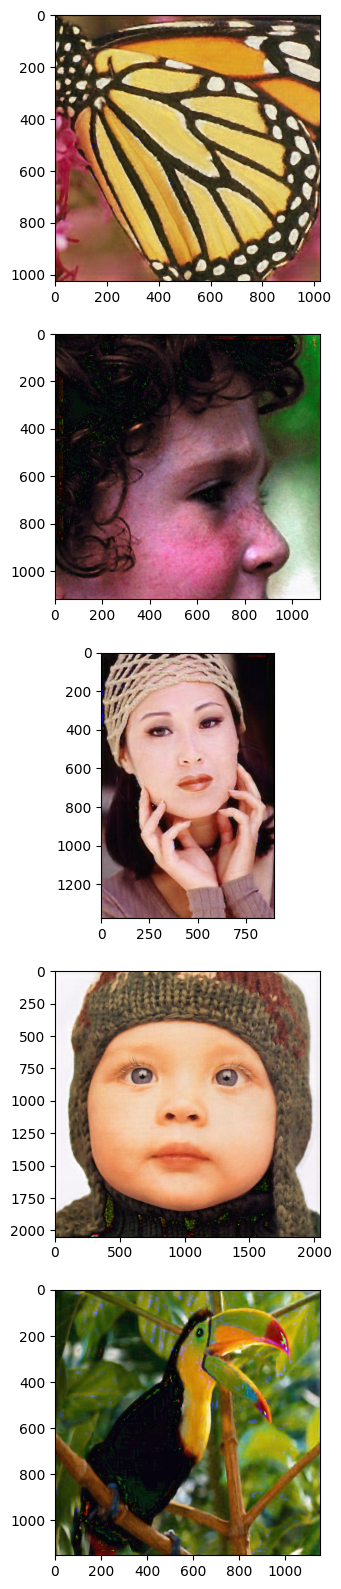

In [27]:
fix, ax = plt.subplots(5, 1, figsize=(40, 20))
for i, img in enumerate(test_images):
    img_tensor = img.unsqueeze(0)
    fake = generator(img_tensor)
    fake_img = fake.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
    fake_img = (fake_img * 255.).astype(np.uint8)
    ax[i].imshow(fake_img)

In [28]:
torch.save(generator.state_dict(), './fine-tune/generator_%03d.pt'%epochs)
torch.save(discriminator.state_dict(), './fine-tune/discriminator%03d.pt'%epochs)